In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from classifier import *
torch.cuda.is_available(), torch.backends.cudnn.enabled

(True, True)

In [8]:
PATH = Path('/home/sean/hpc-home/skin_cancer/dermofit')
%ls $PATH

AK/      ALLDF/   ALLML/   ALLVASC/  iec.zip*         ml.zip*   scc.zip*
ak.zip*  ALLIEC/  ALLSCC/  bcc.zip*  lesionlist.txt*  PYO/      sk.zip*
ALLBCC/  ALLMEL/  ALLSK/   df.zip*   mel.zip*         pyo.zip*  vasc.zip*


In [39]:
imgd = PATH
labels_txt = PATH / 'lesionlist.txt'

train_csv = PATH / 'train.csv' # created in this script

PATH.exists(), labels_txt.exists()

(True, True)

## Process CSV for FastAI API

The process for formatting the CSV labels (or other formats) is different for all datasets, so no standard functions. Might have to load labels into a CSV for other datasets (not hard with pandas - pd).

In [25]:
df = pd.read_csv(labels_txt, sep='   ', header=None)
df.head()

/home/sean/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


0      1    2
0  1  D204a  BCC
1  2   D222  SCC
2  3  D226b   ML
3  4  D226c   ML
4  5   D227   ML

In [18]:
lbls = np.unique(np.array(df[2]))
lbls

array(['AK', 'BCC', 'DF', 'IEC', 'MEL', 'ML', 'PYO', 'SCC', 'SK', 'VASC'], dtype=object)

In [20]:
lbl2folder = {k: 'ALL' + k for k in lbls}
lbl2folder['AK'] = 'AK'
lbl2folder['PYO'] = 'PYO'

{'AK': 'AK',
 'BCC': 'ALLBCC',
 'DF': 'ALLDF',
 'IEC': 'ALLIEC',
 'MEL': 'ALLMEL',
 'ML': 'ALLML',
 'PYO': 'PYO',
 'SCC': 'ALLSCC',
 'SK': 'ALLSK',
 'VASC': 'ALLVASC'}

In [31]:
np.array(df[1]).dtype

dtype('O')

In [36]:
folder_n = np.array([lbl2folder[k] for k in df[2]])
index_arr = (folder_n.astype('O') + '/' + np.array(df[1]) + '/' + np.array(df[1])).astype(str)
index_arr

array(['ALLBCC/D204a/D204a', 'ALLSCC/D222/D222', 'ALLML/D226b/D226b', ..., 'ALLIEC/P100/P100',
       'ALLIEC/T239/T239', 'ALLIEC/T39/T39'], dtype='<U21')

In [37]:
df_d = {'class': list(df[2])}
tdf = pd.DataFrame(df_d, index=index_arr.tolist(), dtype=str)
tdf.head()

class
ALLBCC/D204a/D204a   BCC
ALLSCC/D222/D222     SCC
ALLML/D226b/D226b     ML
ALLML/D226c/D226c     ML
ALLML/D227/D227       ML

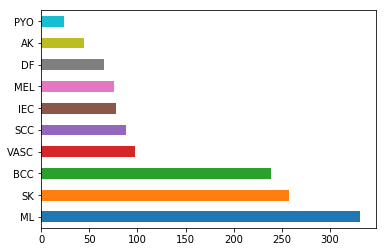

In [38]:
tdf['class'].value_counts().plot(kind='barh')

In [40]:
tdf.to_csv(train_csv)

## Data Loaders

In [60]:
# The network architecture to use, resnet34 is a good start, will get better performance with 
# resnext50 or inception_4
arch=resnet34
# image size
sz=224
bs=64

# Dataset augmentations
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down)
# The dataloader, used for training and evaluation, has numerous useful functions for:
# loading data, preprocessing, batching, obtaining basic stats, and more
data = ImageClassifierData.from_csv(PATH, '', train_csv, tfms=tfms,
                    suffix='.png', bs=bs)

In [46]:
data.classes

['AK', 'BCC', 'DF', 'IEC', 'MEL', 'ML', 'PYO', 'SCC', 'SK', 'VASC']

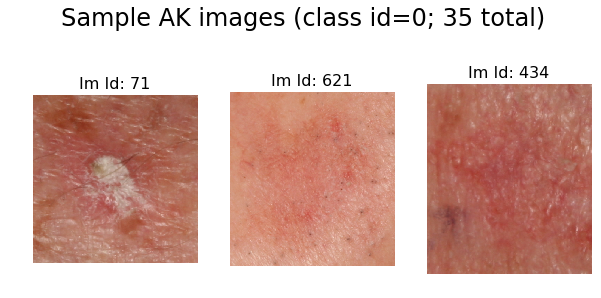

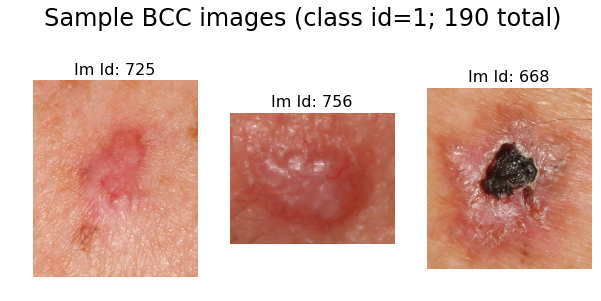

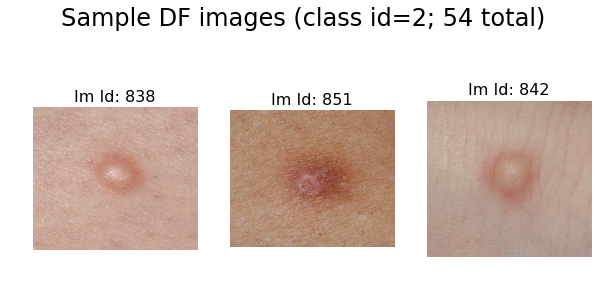

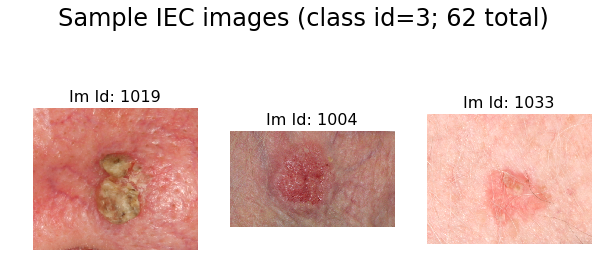

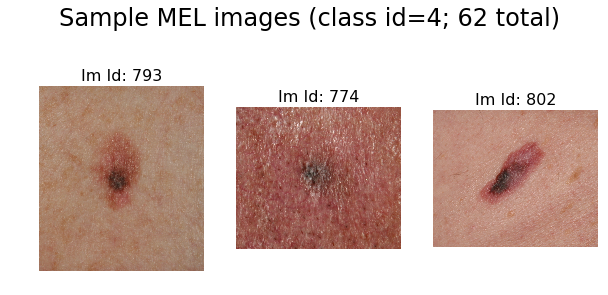

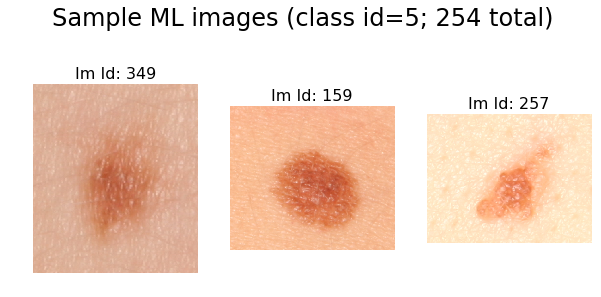

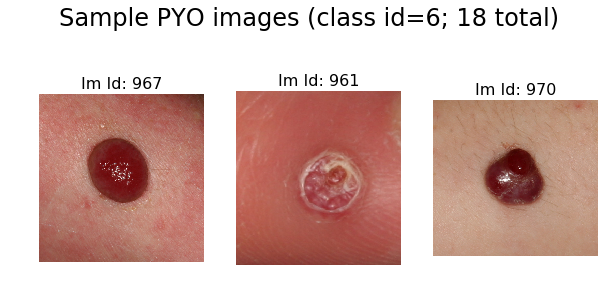

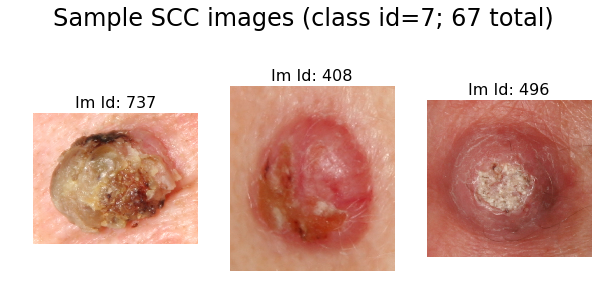

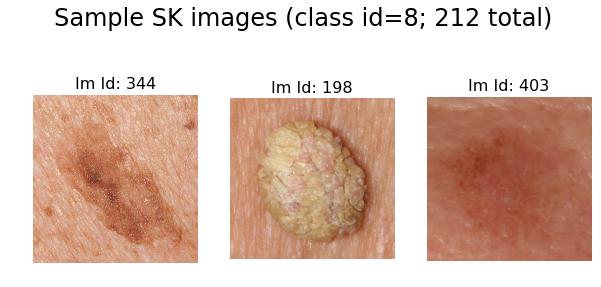

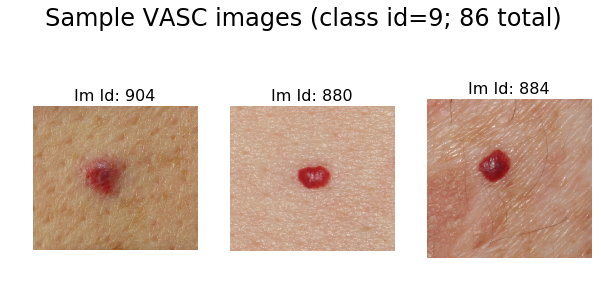

In [52]:
for i in range(min(len(data.classes),10)): sample_ims(PATH, i, data, numimgs=3, figsize=(10,5))

# Setup and Train Network

In [70]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

This can be used to help find the inital learning rate. 

In [61]:
learn.data.bs = 8
lrf=learn.lr_find()
# learn.sched.plot_lr()

 75%|███████▍  | 97/130 [00:00<00:00, 102.42it/s, loss=3.57]


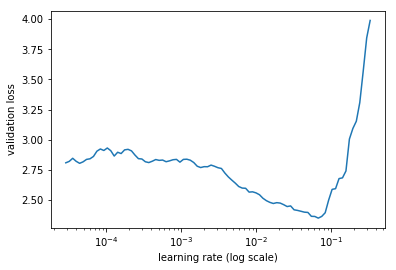

In [62]:
learn.sched.plot()

In [71]:
learn.data.bs = bs
learn.fit(1e-2, 6)

epoch      trn_loss   val_loss   accuracy                
    0      2.165627   1.386042   0.546154  
    1      1.641821   1.09536    0.615385                
    2      1.362784   1.001194   0.630769                
    3      1.163998   0.959612   0.642308                
    4      1.045909   0.93783    0.65                    
    5      0.949279   0.927251   0.665385                 



[array([0.92725]), 0.6653846153846154]

In [72]:
learn.data.bs = max(8, bs // 2)
learn.fit(1e-2, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      0.706913   0.932573   0.665385  
    1      0.680271   0.925469   0.673077                 
    2      0.674204   0.906594   0.676923                 
    3      0.659618   0.907507   0.661538                 



[array([0.90751]), 0.6615384615384615]

In [86]:
None or []

[]

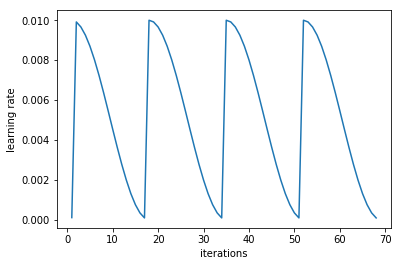

In [74]:
learn.sched.plot_lr()

In [73]:
learn.save('dermofit1')

In [ ]:
learn.load('dermofit1')

In [75]:
learn.precompute = False
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.896124   0.878302   0.676923  
    1      0.911969   0.854119   0.696154                  
    2      0.872816   0.85609    0.696154                  
    3      0.872568   0.835312   0.715385                  
    4      0.841371   0.83321    0.715385                  
    5      0.820958   0.839334   0.723077                  
    6      0.80333    0.844651   0.711538                  



[array([0.84465]), 0.7115384615384616]

In [76]:
learn.save('dermofit2')

In [ ]:
learn.load('dermofit2')

# Evaluations and Visualisations

Accuracy = 0.70                              
Confusion Matrix:
[[ 1  3  0  0  0  1  0  1  4  0]
 [ 0 40  0  0  0  3  0  3  2  1]
 [ 0  1  9  0  0  1  0  0  0  0]
 [ 0  2  1 12  0  0  0  0  0  1]
 [ 0  1  0  2  8  0  0  0  1  2]
 [ 0  1  1  0  2 61  0  0 12  0]
 [ 0  1  1  0  0  0  2  1  0  1]
 [ 1  5  0  0  0  0  0 12  3  0]
 [ 1  2  2  1  0  7  0  2 28  2]
 [ 0  0  1  0  1  1  0  0  0  8]]
AUC for class 0, id AK = 0.92
AUC for class 1, id BCC = 0.96
AUC for class 2, id DF = 0.96
AUC for class 3, id IEC = 0.99
AUC for class 4, id MEL = 0.97
AUC for class 5, id ML = 0.96
AUC for class 6, id PYO = 0.98
AUC for class 7, id SCC = 0.95
AUC for class 8, id SK = 0.89
AUC for class 9, id VASC = 0.98
----------------------------------------
[[ 1  3  0  0  0  1  0  1  4  0]
 [ 0 40  0  0  0  3  0  3  2  1]
 [ 0  1  9  0  0  1  0  0  0  0]
 [ 0  2  1 12  0  0  0  0  0  1]
 [ 0  1  0  2  8  0  0  0  1  2]
 [ 0  1  1  0  2 61  0  0 12  0]
 [ 0  1  1  0  0  0  2  1  0  1]
 [ 1  5  0  0  0  0  0 12 

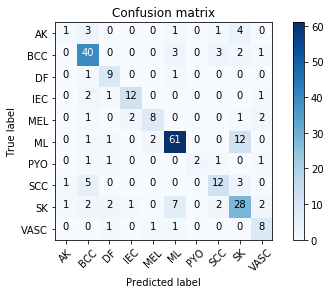

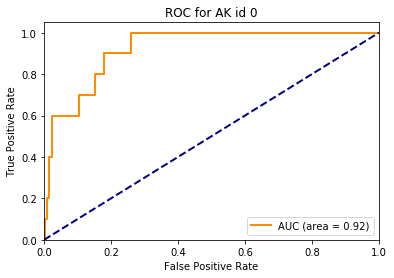

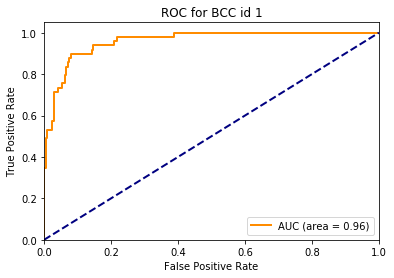

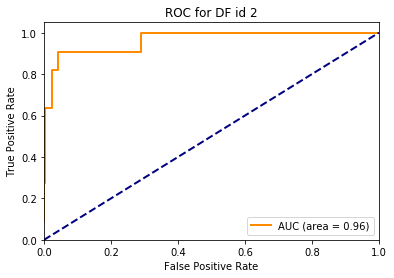

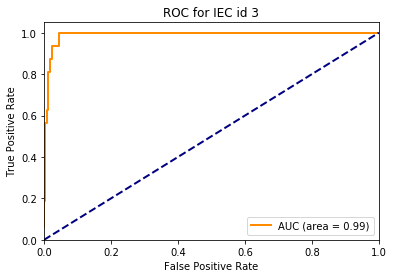

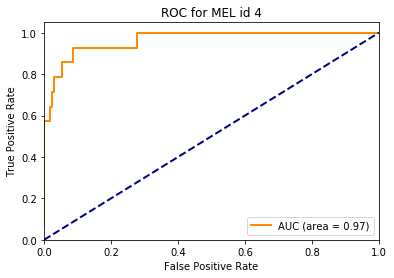

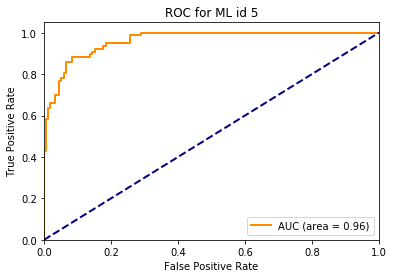

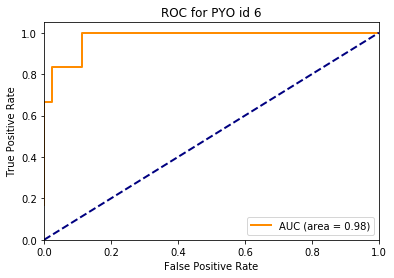

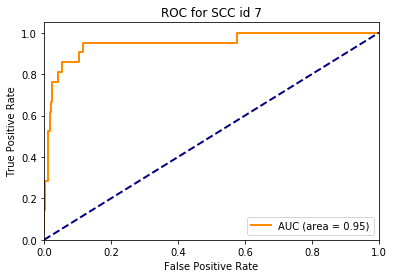

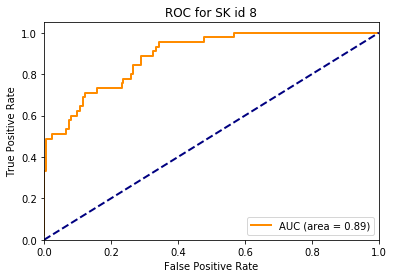

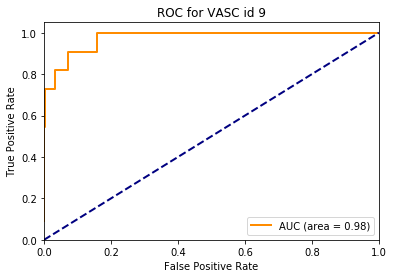

In [77]:
vf_preds, vy, vacc, vcm, vroc_auc, vfpr, vtpr = run_test(learn, sf=True)

Text(0.5,1,'Val network predictions distribution')

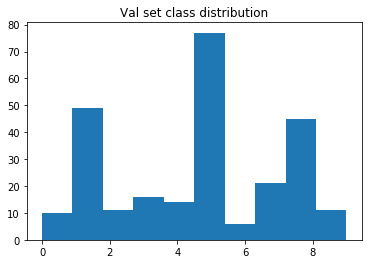

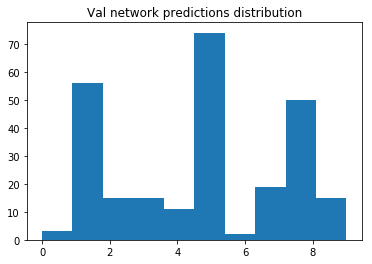

In [79]:
plt.hist(vy, align='mid')
plt.title('Val set class distribution')
plt.figure()
plt.hist(vf_preds, align='mid')
plt.title('Val network predictions distribution')

In [80]:
logpr = learn.predict()
preds = np.argmax(np.exp(logpr), axis=1)

In [81]:
probs = logpr[np.arange(logpr.shape[0]), preds]
probs.shape, logpr.shape

((260,), (260, 10))

In [82]:
def visualise(learner, d):
    logpr = learner.predict()
    preds = np.argmax(np.exp(logpr), axis=1)
    probs = logpr[np.arange(logpr.shape[0]), preds]
    plot_val_with_title(d, probs,preds, rand_by_correct(True, preds, d.val_y), "Correctly classified")
    plot_val_with_title(d, probs,preds, rand_by_correct(False, preds, d.val_y), "Incorrectly classified")
    for i, c in enumerate(d.classes):
        plot_val_with_title(d, probs,preds, most_by_correct(i, True, preds, probs, d.val_y), "Most correct {}".format(c))
    

Correctly classified
Incorrectly classified
Most correct AK
Most correct BCC
Most correct DF
Most correct IEC
Most correct MEL
Most correct ML
Most correct PYO
Most correct SCC
Most correct SK
Most correct VASC


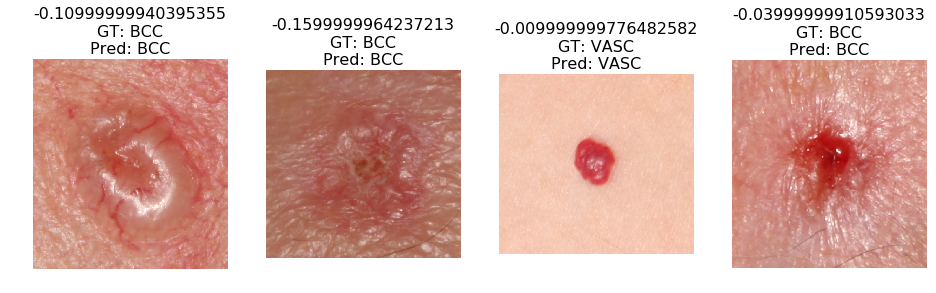

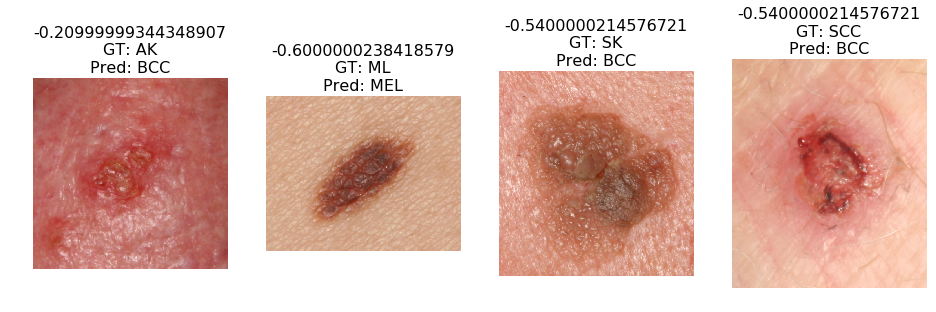

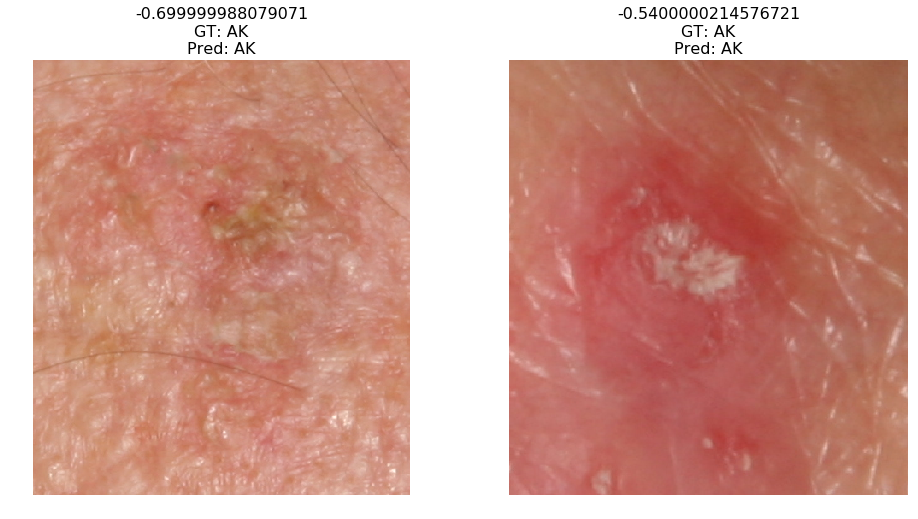

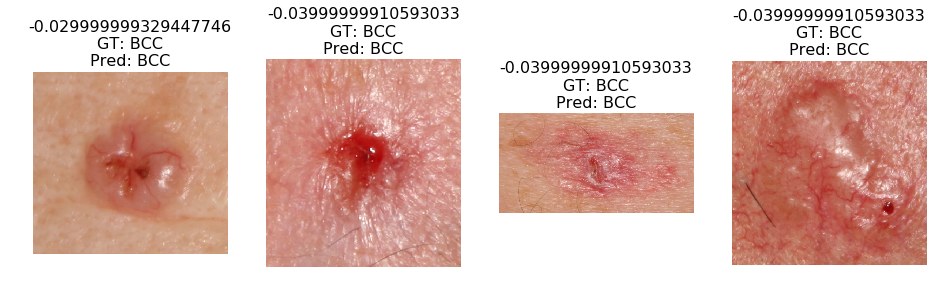

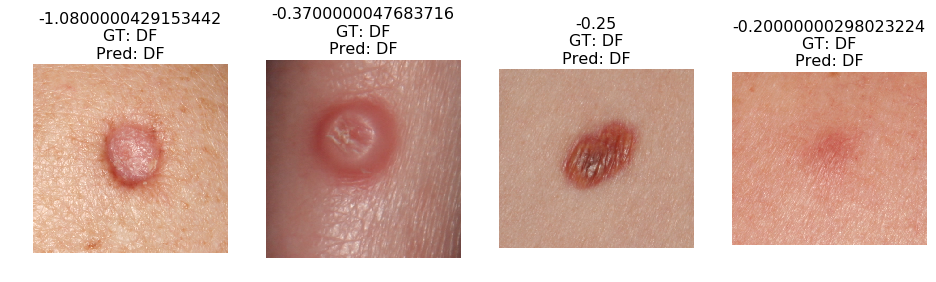

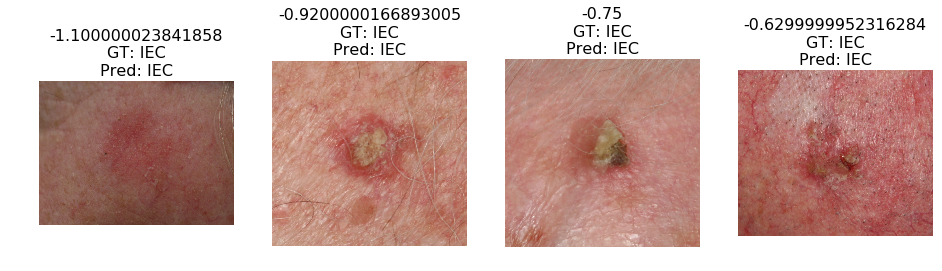

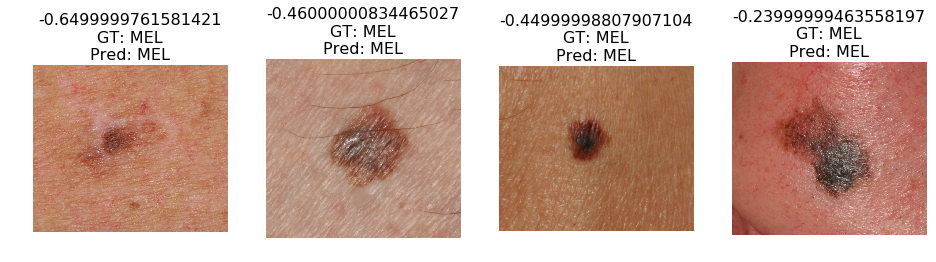

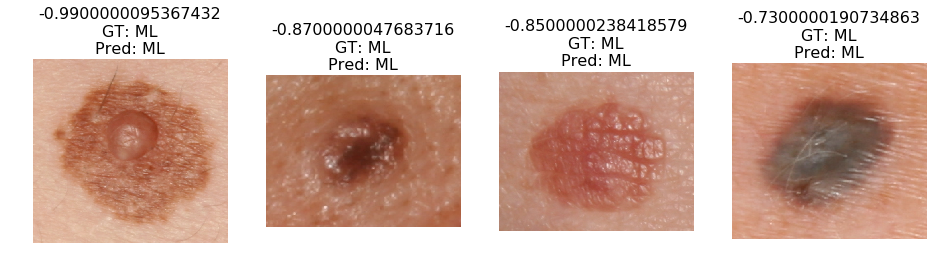

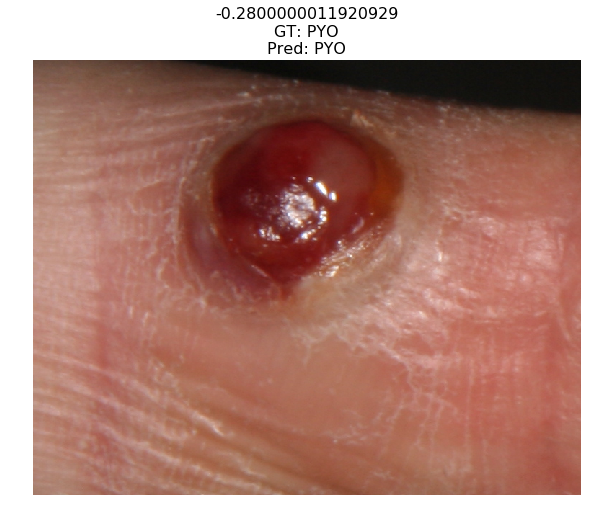

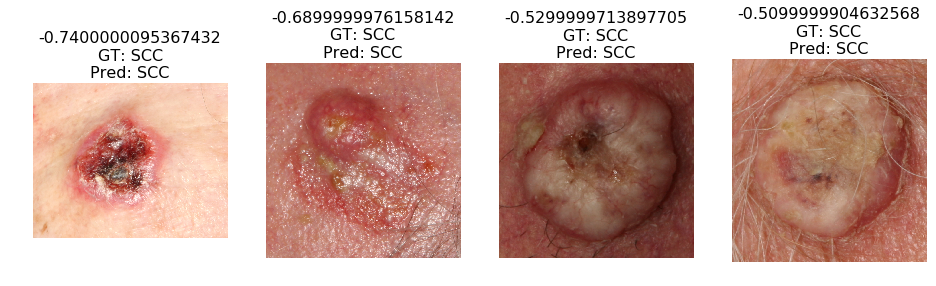

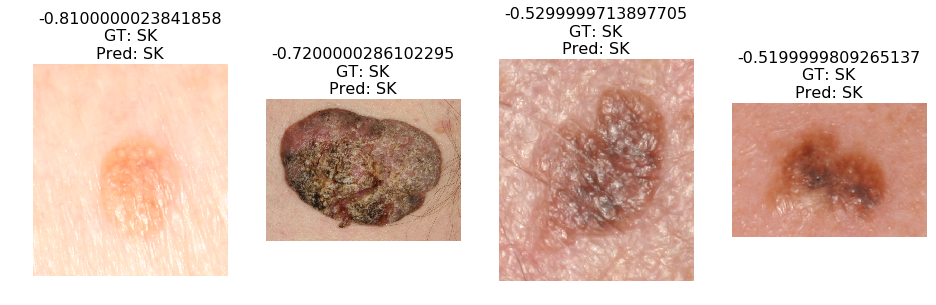

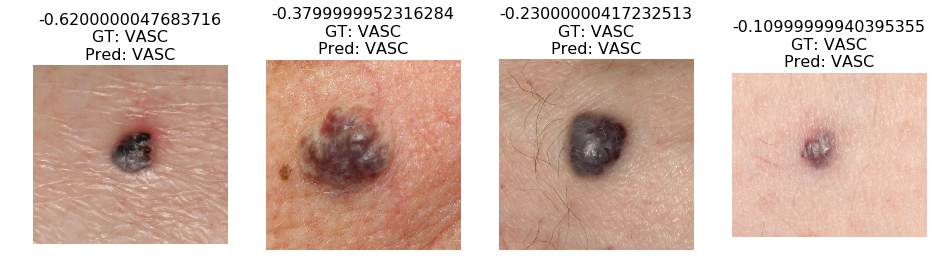

In [83]:
visualise(learn, data)